# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for Meterological Data as it comes off the TELOS/FLOT system.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [66]:
import pandas as pd
import yaml

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [67]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2024/Moorings/24bspr2a/'

In [172]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'working/24BSPR-2A_preliminary_Met.10min.edited.csv'
instrument = 'met_telos'
mooring_meta_file = user_data_dir+'logs/24BSPR-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/telos_wx_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'met_telos'
###############################################################


#init and load data
#10min or 1hr data are available usually from telos driven met packages
met_df = pd.read_csv(datafile,parse_dates=True,index_col='time (UTC)')

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_12480/812849201.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  met_df = pd.read_csv(datafile,parse_dates=True,index_col='time (UTC)')


In [173]:
met_df

,PAR,Pitch,Roll,Temperature,BaroPres,BP_Std,Air_Temp,Air_Temp_Std,RH,RH_Std,ShortWaveRad,U_wind,Uwind_Std,V_wind,Vwind_Std,Wind_Speed,Gust,Compass,wind_speed,wind_from_direction
time (UTC),,,,,,,,,,,,,,,,,,,,
2024-05-17 04:00:00,376.12,-3.15,1.06,12.31,1018.66,0.31,3.17,0.02,87.7,0.1,212.97,2.4,2.3,2.2,2.3,4.5,6.0,244.9,3.255764,227.489553
2024-05-17 04:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.59,1.7,2.4,2.5,1.8,4.2,5.5,147.9,3.023243,214.215702
2024-05-17 04:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.89,2.3,1.8,2.5,1.9,4.2,5.6,222.3,3.397058,222.614056
2024-05-17 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.44,2.2,1.7,2.4,1.9,4.1,5.0,179.1,3.255764,222.510447
2024-05-17 04:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.95,2.0,1.8,2.6,1.6,4.0,5.1,170.0,3.280244,217.568592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.70,-1.6,0.5,0.0,0.5,1.6,2.4,346.6,1.600000,90.000000
2024-09-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.48,-2.7,0.5,0.2,0.7,2.8,3.7,337.1,2.707397,94.236395
2024-09-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.13,-2.6,0.5,0.5,0.6,2.7,3.5,350.4,2.647640,100.885527


In [174]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


<Figure size 640x480 with 0 Axes>

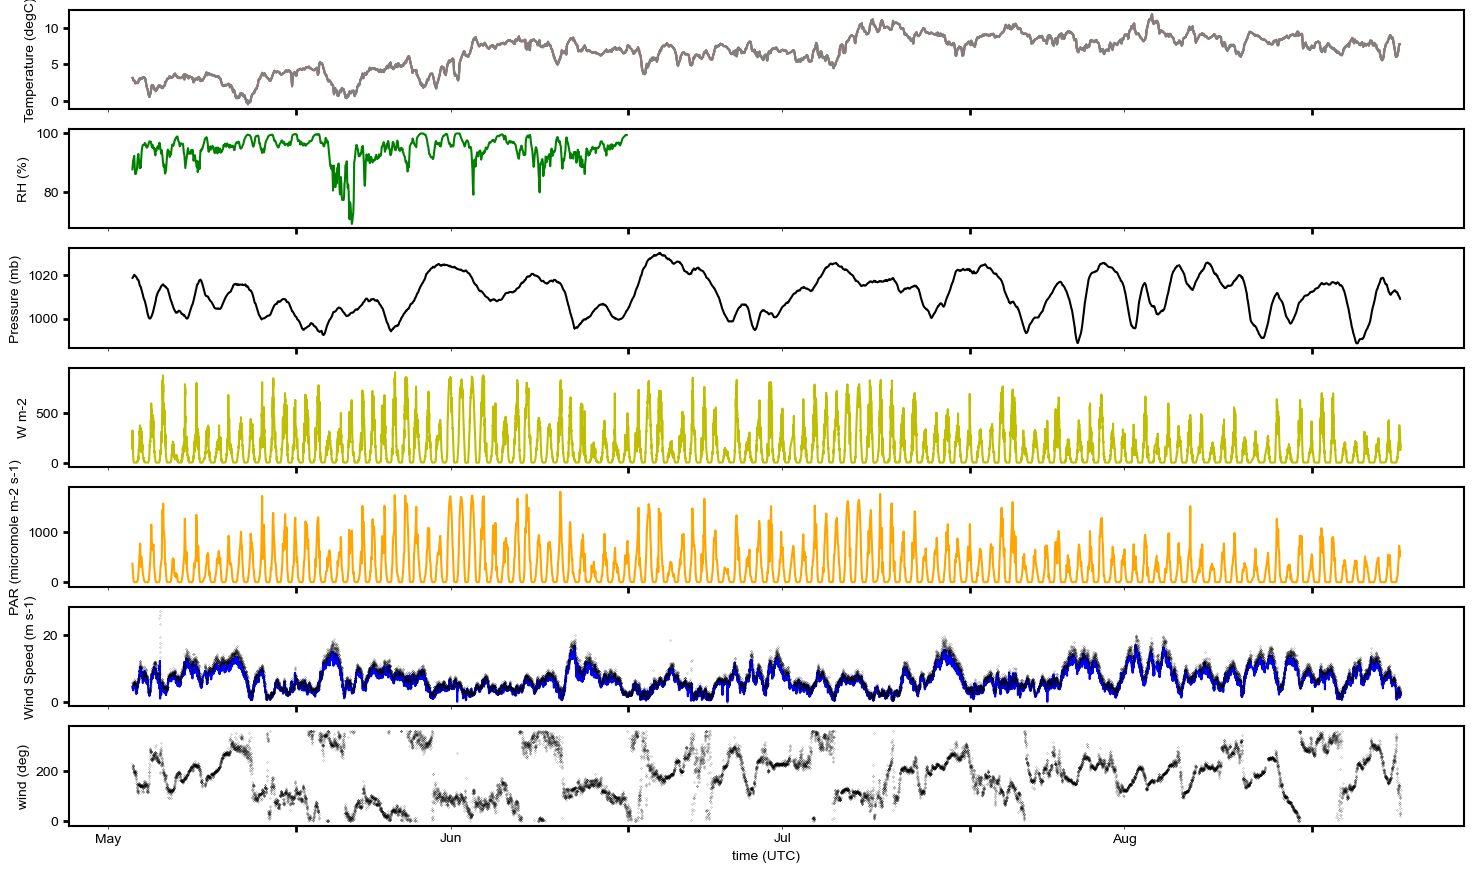

In [175]:
fig, ax = plt.subplots(7,figsize=(18, 12),sharex=True)
met_df.Air_Temp.dropna().plot(ax=ax[0],c='r')
(met_df.Air_Temp.dropna()+met_df.Air_Temp_Std.dropna()).plot(ax=ax[0],c='grey')
(met_df.Air_Temp.dropna()-met_df.Air_Temp_Std.dropna()).plot(ax=ax[0],c='grey')
ax[0].set_ylabel('Temperature (degC)')
met_df.RH.dropna().plot(ax=ax[1],c='g')
ax[1].set_ylabel('RH (%)')
met_df.BaroPres.dropna().plot(ax=ax[2],c='k')
ax[2].set_ylabel('Pressure (mb)')
met_df.ShortWaveRad.dropna().plot(ax=ax[3],c='y')
ax[3].set_ylabel('W m-2')
met_df.PAR.dropna().plot(ax=ax[4],c='orange')
ax[4].set_ylabel('PAR (micromole m-2 s-1)')
met_df['Wind_Speed'].dropna().plot(ax=ax[5],c='b')
met_df['Gust'].dropna().plot(ax=ax[5],c='k',style='.',markersize=.25)
ax[5].set_ylabel('Wind Speed (m s-1)')
met_df['wind_from_direction'].dropna().plot(ax=ax[6],c='k',style='.',markersize=.25)
ax[6].set_ylabel('wind (deg)')

ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))

In [176]:
## Modify the raw file for whatever remaing QC you want to apply

In [177]:
met_df.columns

Index(['PAR', 'Pitch', 'Roll', 'Temperature', 'BaroPres', 'BP_Std', 'Air_Temp',
       'Air_Temp_Std', 'RH', 'RH_Std', 'ShortWaveRad', 'U_wind', 'Uwind_Std',
       'V_wind', 'Vwind_Std', 'Wind_Speed', 'Gust', 'Compass', 'wind_speed',
       'wind_from_direction'],
      dtype='object')

In [178]:
## change variable names if needed to match TELOS yaml expectations

In [179]:
met_df.index = met_df.index.rename('date_time')
met_df = met_df.rename(columns={'BaroPres':'pressure',
                                'Temperature':'PAR_Temp',
                                  'Air_Temp':'temperature',
                                  'U_wind':'northward_wind',
                                  'V_wind':'eastward_wind',
                                  'Wind_Speed':'wind_speed_',
                                  'Gust':'wind_speed_gust',
                                  'RH':'relative_humidity',
                                'wind_from_direction':'wind_direction',
                                'ShortWaveRad':'swrad',
                                'PAR':'par'
                                  })
met_df.sample()

,par,Pitch,Roll,PAR_Temp,pressure,BP_Std,temperature,Air_Temp_Std,relative_humidity,RH_Std,swrad,northward_wind,Uwind_Std,eastward_wind,Vwind_Std,wind_speed_,wind_speed_gust,Compass,wind_speed,wind_direction
date_time,,,,,,,,,,,,,,,,,,,,
2024-07-28 18:00:00,315.69,-2.54,-0.83,16.16,1002.25,0.0,9.16,0.01,NaN,NaN,149.69,4.1,3.4,7.3,1.9,9.2,10.7,81.5,8.372574,209.320476


## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [180]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [181]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [182]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [183]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
met_wop_nc = ncCFsave.EcoFOCI_CFnc(df=met_df, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
met_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [184]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
met_wop_nc.expand_dimensions()

In [185]:
met_wop_nc.variable_meta_data(variable_keys=list(met_df.columns.values),drop_missing=True)
# met_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
met_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [186]:
#add global attributes
met_wop_nc.deployment_meta_add()
met_wop_nc.get_xdf()

#add instituitonal global attributes
met_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
# met_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
met_wop_nc.provinance_meta_add()

#provide intial qc status field
met_wop_nc.qc_status(qc_status='unknown')

In [187]:
met_wop_nc.get_xdf()

<xarray.Dataset> Size: 1MB
Dimensions:            (time: 16537, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time               (time) datetime64[ns] 132kB 2024-05-17T04:00:00 ... 20...
  * latitude           (latitude) float64 8B 1e+35
  * longitude          (longitude) float64 8B 1e+35
  * depth              (depth) float64 8B 1e+35
Data variables:
    par                (time, depth, latitude, longitude) float64 132kB 376.1...
    pressure           (time, depth, latitude, longitude) float64 132kB 1.019...
    temperature        (time, depth, latitude, longitude) float64 132kB 3.17 ...
    relative_humidity  (time, depth, latitude, longitude) float64 132kB 87.7 ...
    swrad              (time, depth, latitude, longitude) float64 132kB 213.0...
    northward_wind     (time, depth, latitude, longitude) float64 132kB 2.4 ....
    eastward_wind      (time, depth, latitude, longitude) float64 132kB 2.2 ....
    wind_speed         (time, depth, latitude, longitude) float64 132kB 3.256...
    wind_direction     (time, depth, latitude, longitude) float64 132kB 227.5...
Attributes: (12/28)
    MooringID:                              24BSPR-2A
    platform_deployment_date:               2024-05-17T05:00:00Z
    platform_deployment_cruise_name:        DY2406
    platform_recovery_date:                 2024-09-09T02:31:53Z
    platform_recovery_cruise_name:          DY2410
    platform_deployment_recovery_comments:  
    ...                                     ...
    references:                             
    citation:                               
    acknowledgement:                        
    date_created:                           2025-03-28T14:49:10Z
    date_modified:                          
    QC_indicator:                           unknown

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [192]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = ''
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'.nc'
met_wop_nc.xarray2netcdf_save(xdf = met_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'minutes' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})
